In [1]:
import numpy as np
import matplotlib.pyplot as plt

import SD_functions as SDF
import scipy.stats
import pandas as pd
import seaborn as sns
import responseModel as RM

pi=np.pi
r2d,d2r = 180/pi,pi/180

n_bns=91
bns = np.linspace(-90,90,n_bns)
bns_c = bns[:-1] + (bns[1]-bns[0])/2
r_bns = np.linspace(-pi,pi,n_bns)
pal = ['k','c']
mdl_fun ='DoVM' # can also use 'DoG' to compare with previous work
n_subj,n_trial = 30,360

In [2]:
def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

# Section 1: Simulate without history independent biases
Here we simulate observers featuring either stimulus, response, or no serial dependance. For simplicity we simply generate a bunch of trials (20k) and later split those trials up into different 'participants' for the purpose of visualization/stats. The simulation allows you to vary the precision of the observer *kappa* as well as the general strength of the contextual prior, *p_same*.

We next summarize the biases of the resulting responses both non-parametrically, by visualizing a sliding circular mean $\pm$ SEM accross 'participants', and by parameterizing stimulus and response biases using a derivative of Von Mises function. *nb* refers to the "number of trial back" used for contextual bias analysis. *nb=-1* is the standard serial dependance analysis of the previous trial while *nb=0/shuffle* is the same analysis performed after shuffling the trial order. *nb=1* is an additional control examining the influence of the future stimulus/response. 

In [3]:
do_cb,do_oblique = 0,0
M0 = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique)

In [4]:
nb_use = (-1,1,0)
S0 = RM.summarize_sim(*M0,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,)

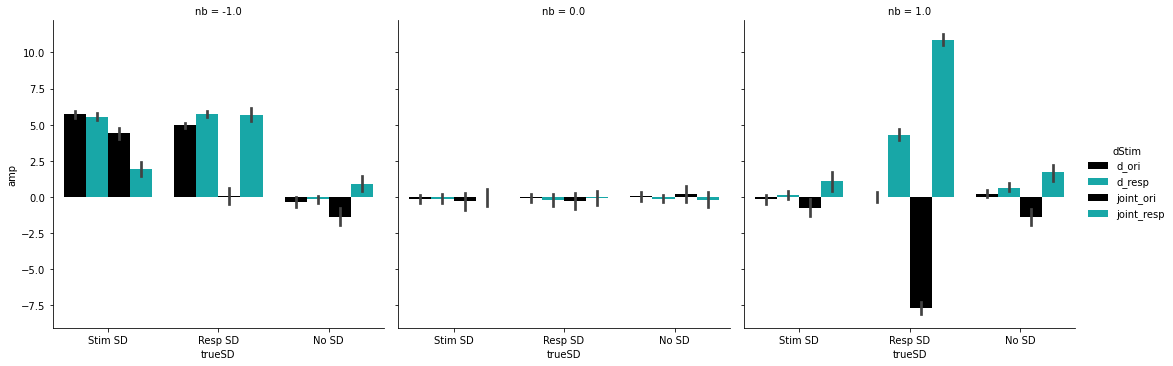

ignoring nan values!


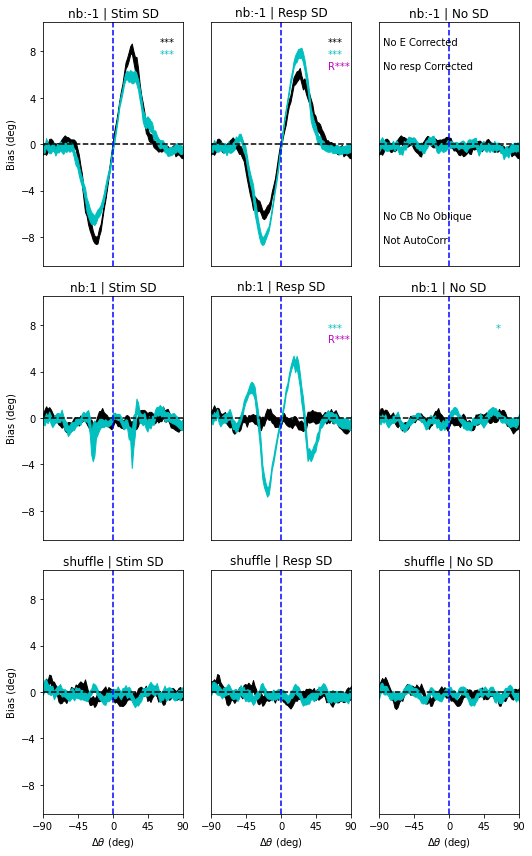

In [5]:
nb_use = (-1,1,0)
sns.catplot(data=S0[0],x='trueSD',hue='dStim',col='nb',y='amp',kind='bar',palette=pal,ci=68)
# sav_fig('F2_noCB_all_bar')
plt.show()

ann = (0,0,0,do_cb,do_oblique)
RM.vis_bias(S0[1],nb_use,stats=S0[0],ann=ann,yl=10.5)
# sav_fig('F2_noCB_all')
plt.show()

## Box 1: why do we get N+1 artifact?
(**TL**) First we examine P($\Delta R$) for the previous and future trial when there are true response biases. The distribution is clearly non-uniform for future responses. This is because the future response is driven in part by the prior established on the current trial and centered on the current response. This anisotropy is true even when bias source is the stimulus as indicated by the black trace.

(**TR**) The prior for response bias on the future trial differs as a function of the direction of the error on the current trial. Here we visualize errors of the average absolute magnitude of our simulated observer.

(**BL**) These shifting priors mean that P($\Delta R_{N+1}$) differs as a function of the error on the current trial for response driven biases. Note that when the underlying source of the bias is the previous stimulus (black outline), P($\Delta R_{N+1}$) is not effected by the response on the previous trial (black lines drawn seperately for CW and CCW errors.

(**BR**) The resulting bias as a function of $\Delta R_{N+1}$ for response biases (teal) is captured by mutliplying the average absolute error by the relative proportion of CW response for a given value of $\Delta R_{N+1}$ (gray trace).

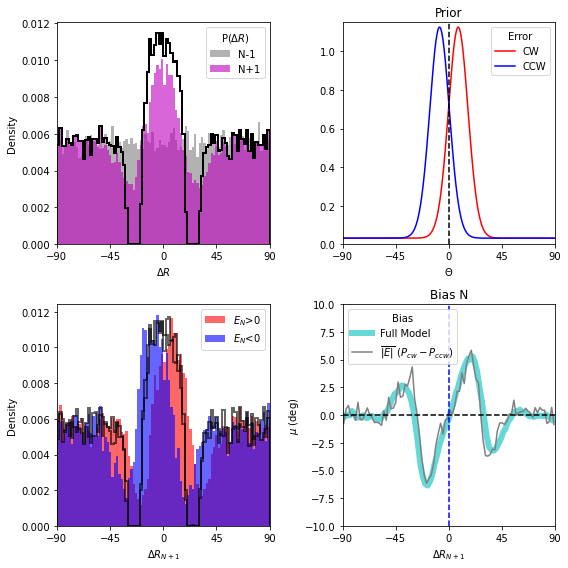

In [6]:
i=1 # what gives rise to the underlying bias (stim, resp, none)
overlap=3
n_step = 1000
s_0 = np.linspace(0,180,n_step) 
kappa_prior = 8*1.5
p_same = 0.8
al=0.6

E_use = M0[2] 
d_resp = RM.ori_wrap(SDF.get_nb(-1,M0[1][i],0)-M0[0]) # dR_N-1 (for response bias sim)
d_resp_future = RM.ori_wrap(SDF.get_nb(1,M0[1][i],0)-M0[0]) # dR_N+1 (for response bias sim)
d_resp_future_stim_bias = RM.ori_wrap(SDF.get_nb(1,M0[1][0],0)-M0[0]) # dR_N+1 (for stim bias sim)
resp_cur_trial = M0[2][i]>0 # current response CW/CCW
resp_cur_trial_stim_bias = M0[2][0]>0 # current response CW/CCW

this_bias_future =  SDF.do_bining(bns,overlap,d_resp_future,E_use[i]*d2r*2,'circ_mean')/d2r/2
mE = np.mean(np.abs(E_use[1]))

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
# dR for N-1 and N+1. Note strong 
plt.hist(d_resp,bns,label='N-1',histtype='stepfilled',color='gray',density=1,alpha=al) # dR_N-1 (for response bias sim)
plt.hist(d_resp_future,bns,label='N+1',histtype='stepfilled',color='m',density=1,alpha=al) # dR_N+1 (for response bias sim)
plt.hist(d_resp_future_stim_bias,bns,histtype='step',color='k',density=1,alpha=1,linewidth=2) # dR_N+1 (for stim bias sim)

plt.legend(title='P($\Delta R$)')
plt.xlabel('$\Delta R$')
plt.ylabel('Density')
SDF.d_plot(0,0,-90)

plt.subplot(2,2,2)
prior_resp0 = RM.cf(s_0,90+mE,kappa=kappa_prior,p_same=p_same)
prior_resp1 = RM.cf(s_0,90-mE,kappa=kappa_prior,p_same=p_same)
plt.plot(s_0-90,prior_resp0,'r',label='CW')
plt.plot(s_0-90,prior_resp1,'b',label='CCW')
plt.legend(title='Error')
plt.title('Prior')
SDF.d_plot(0,0,-90)
_yl = [0,1.15]
plt.plot([0,0],_yl,'k--')
plt.ylim(_yl)
plt.xlabel('$\Theta$')

plt.subplot(2,2,3)
h0= plt.hist(d_resp_future[resp_cur_trial],bns,label='$E_N$>0',histtype='stepfilled',color='r',density=1,alpha=al)
h1= plt.hist(d_resp_future[~resp_cur_trial],bns,label='$E_N$<0',histtype='stepfilled',color='b',density=1,alpha=al)

plt.hist(d_resp_future_stim_bias[~resp_cur_trial_stim_bias],bns,histtype='step',color='k',density=1,alpha=al,linewidth=2)
plt.hist(d_resp_future_stim_bias[resp_cur_trial_stim_bias],bns,histtype='step',color='k',density=1,alpha=al,linewidth=2)
# plt.legend(title='$\Delta$ R')
plt.legend()
plt.xlabel('$\Delta R_{N+1}$')
plt.ylabel('Density')
SDF.d_plot(0,0,-90)
# plt.title('N+1')

plt.subplot(2,2,4)
p_cw = h0[0]/(h0[0]+h1[0])

plt.plot(bns,this_bias_future,'c',label='Full Model',linewidth=6,alpha=al)
plt.plot(bns_c,mE*(p_cw*2-1),'gray',label='$\\overline{ |E|}~ (P_{cw}-P_{ccw}$)')
plt.legend(title='Bias')
SDF.d_plot(1,10,-90)
# plt.xlabel('$\Delta$R')
plt.xlabel('$\Delta R_{N+1}$')
plt.ylabel('$\mu$ (deg)')
plt.title('Bias N')
plt.tight_layout()
# sav_fig('N+1_artifact_summary')
plt.show()


## Section 2: Add cardinal bias, oblique effect, and corrections.
Here we introduce cardinal bias into the encoding process of our observers. We additionally apply a correction to their errors in an attempt to correct for this bias. We then visualize the impact of the bias and subsequent correction on our measured history biases.

In [7]:
do_cb,do_oblique = 1,1
M1 = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique)
M1c = RM.correct_cb(*M1,mode='E',n_subj=n_subj,n_trial=n_trial) # correct for cardinal bias

In [8]:
# nb_use = (-1,0)
nb_use = (-1,1,0) # sleeker figure
S1 = RM.summarize_sim(*M1,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,n_subj=n_subj,n_trial=n_trial)
S1c = RM.summarize_sim(*M1c,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,n_subj=n_subj,n_trial=n_trial)

ignoring nan values!
ignoring nan values!


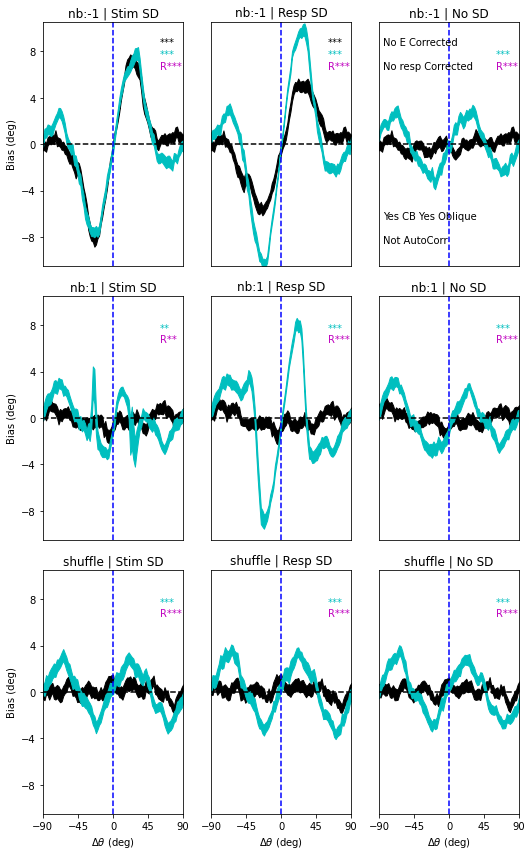

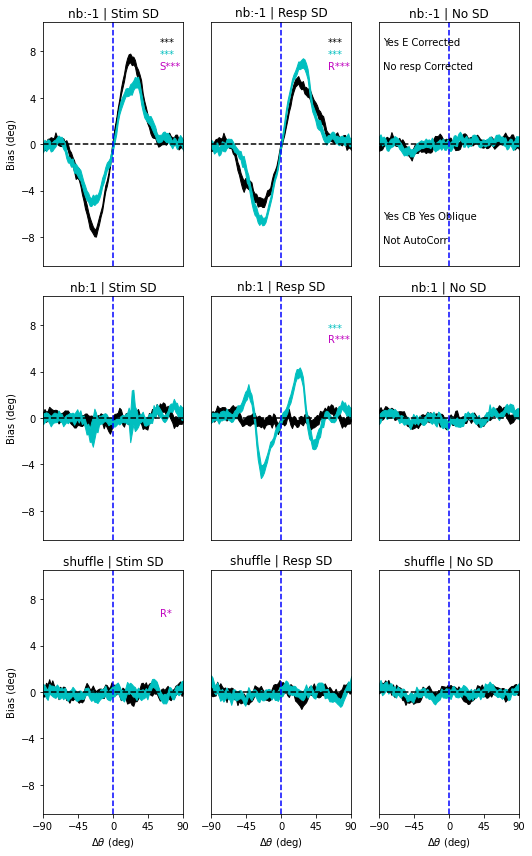

In [9]:
# nb_use = (-1,0) # sleeker figure
do_cb,do_oblique = 1,1
ann = (0,0,0,do_cb,do_oblique)
RM.vis_bias(S1[1],nb_use,stats=S1[0],ann=ann)
# sav_fig('F4_CB_noCorrect_full')

ann = (1,0,0,do_cb,do_oblique)
RM.vis_bias(S1c[1],nb_use,stats=S1c[0],ann=ann)
# sav_fig('F4_CB_yesCorrect_full')
# plt.show()

## Visualize biased and unbiased encoding

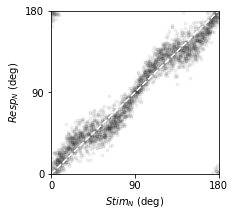

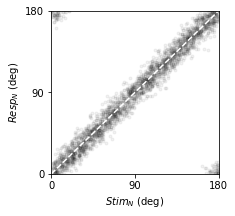

In [10]:
plt.figure(figsize=(3,3))
# plt.subplot(1,2,1)
ds = 8
plt.plot(M1[0][::ds],M1[1][2][::ds],'k.',alpha=.05)
SDF.d_plot(0,0,180)
plt.ylim(0,180)
plt.xlabel('$Stim_N$ (deg)')
plt.ylabel('$Resp_N$ (deg)')
plt.plot([0,180],[0,180],'w--')
plt.yticks([0,90,180])
# sav_fig('F1_enc_bias')
plt.show()

# plt.subplot(1,2,2)
plt.figure(figsize=(3,3))
plt.plot(M0[0][::ds],M0[1][2][::ds],'k.',alpha=.05)
SDF.d_plot(0,0,180)
plt.ylim(0,180)
plt.xlabel('$Stim_N$ (deg)')
plt.ylabel('$Resp_N$ (deg)')
plt.plot([0,180],[0,180],'w--')
plt.yticks([0,90,180])
# sav_fig('F1_enc_Nobias')
plt.show()

## Visualize Bayesian inference portion of model

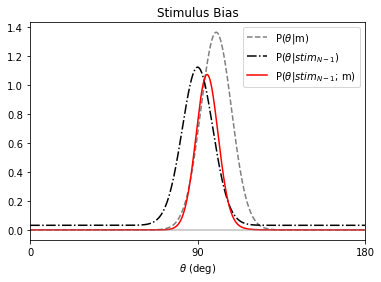

In [11]:
want_resp = 0
kappa = 12
prev_stim = 90
prev_resp = 110
curr_stim = 100
prior_stim = RM.cf(s_0,prev_stim,kappa=kappa,p_same = 0.8)
prior_resp = RM.cf(s_0,prev_resp,kappa=kappa,p_same = 0.8)
lik_stim = RM.c(s_0,curr_stim,kappa=kappa)
post_stim = prior_stim*lik_stim
post_resp = prior_resp*lik_stim

# plt.figure(figsize=(4,4))
plt.plot(s_0,lik_stim,'k--',alpha=.5,label='P($\\theta$|m)')
if want_resp:
    plt.plot(s_0,prior_resp,'c-.',label='P($\\theta$|$resp_{N-1}$)')
    plt.plot(s_0,post_resp,'r-',label='P($\\theta$|$resp_{N-1}$; m)')
else:
    plt.plot(s_0,prior_stim,'k-.',label='P($\\theta$|$stim_{N-1}$)')
    plt.plot(s_0,post_stim,'r-',label='P($\\theta$|$stim_{N-1}$; m)')

plt.legend()
# plt.plot(s_0,prior_resp,'c')
plt.xlabel('$\\theta$ (deg)')

SDF.d_plot(0,0,180)
plt.plot([0,180],[0,0],'gray',alpha=.5)
if want_resp:
    plt.title('Response Bias')
    sav_fig('F1_respBias')
else:
    plt.title('Stimulus Bias')
    sav_fig('F1_stimBias')
    

## Visualize correction for bias and biaseing functions.

Shown on right is the measured cardinal bias of raw errors and our fit model to correct for them. This fit effectively removes the influence of cardinal bias as the resulting residuals are not biased as a function of the stimulus identity. This correction procedure is still effective when it is applied to responses exibiting response serial dependance.

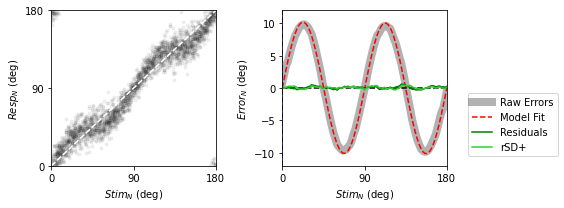

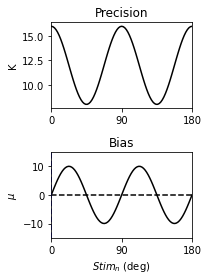

In [12]:
correction_fun,bias = RM.correct_cb(*M1,mode='fit_fun')

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(M1[0][::ds],M1[1][2][::ds],'k.',alpha=.05)
SDF.d_plot(0,0,180)
plt.ylim(0,180)
plt.xlabel('$Stim_N$ (deg)')
plt.ylabel('$Resp_N$ (deg)')
plt.plot([0,180],[0,180],'w--')
plt.yticks([0,90,180])

plt.subplot(1,2,2)

plt.plot(bns+90,bias[0],color='gray',alpha=al,linewidth=8,label='Raw Errors') # uncorrected bias
plt.plot(bns+90,correction_fun(r_bns),'r--',label='Model Fit')
SDF.d_plot(1,12,180)
plt.plot(bns+90,bias[3],'g',label='Residuals',)
# plt.plot(bns+90,bias[1],'olive',label='SD+',)  # stimulus serial dependance (present when fitting CB)
plt.plot(bns+90,bias[2],'limegreen',label='rSD+',)  # response serial dependance (present when fitting CB)
plt.legend(bbox_to_anchor=(1.1,.5))
plt.xlabel('$Stim_N$ (deg)')
plt.ylabel('$Error_N$ (deg)')
plt.tight_layout()
# sav_fig('F4_CardinalBiasModeling')
plt.show()

mu = RM.cb_fun_bias(bns+90)
kappa = RM.cb_fun_kappa(bns+90)
plt.figure(figsize=(3,4))
plt.subplot(2,1,1)
plt.plot(bns+90,kappa,'k')
plt.title('Precision')
plt.ylabel('K')
SDF.d_plot(0,0,180)

plt.subplot(2,1,2)
plt.plot(bns+90,mu,'k')
plt.title('Bias')
plt.ylabel('$\mu$')
# plt.legend()
SDF.d_plot(1,15,180)
plt.xlabel('$Stim_n$ (deg)')
plt.tight_layout()
# sav_fig('F4_CardinalBiasSource')
plt.show()

## Box 2: why cardinal bias --> spurious bias

<ipython-input-13-5a04bd820ebf>:23: UserWarning: linewidths is ignored by contourf
  plt.contourf(counts,extent=[0,180,-90,90],linewidths=3,cmap='binary_r')


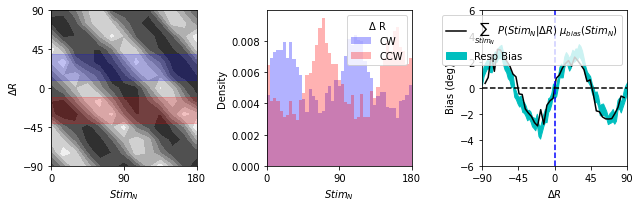

In [13]:
import matplotlib.patches as patches
w_bns = np.linspace(-90,90,46)
rng_view0 = (10,40)
rng_view1 = (-40,-10)
ori_wrap = lambda x: SDF.wrap(x*2)/2

ind_use = 2 # for response generation
d_resp_this = ori_wrap(SDF.get_nb(-1,M1[1][ind_use],0)-M1[0])
d_ori_this = SDF.get_nb(-1,M1[0],1,ori_wrap)
these_ind0 = (d_resp_this>rng_view0[0])&(d_resp_this<rng_view0[1])
these_ind1 = (d_resp_this>rng_view1[0])&(d_resp_this<rng_view1[1])




plt.figure(figsize=(9,3))
ax = plt.subplot(1,3,1)

n_bin = 46
hh = plt.hist2d(M1[0]-90,d_resp_this,n_bin,cmap='gist_yarg_r',density=1,) # gist_yarg

counts,ybins,xbins,image = plt.hist2d(M1[0],d_resp_this,13)#,norm=LogNorm())
plt.contourf(counts,extent=[0,180,-90,90],linewidths=3,cmap='binary_r')
rect0 = patches.Rectangle((0, rng_view0[0]), 180, 30, linewidth=1, edgecolor='b', facecolor='b',alpha=.2)
rect1 = patches.Rectangle((0, rng_view1[0]), 180, 30, linewidth=1, edgecolor='r', facecolor='r',alpha=.2)

# Add the patch to the Axes
ax.add_patch(rect0)
ax.add_patch(rect1)

SDF.d_plot(0,0,-90)
plt.yticks([-90,-45,0,45,90])
plt.ylabel('$\Delta R$')
plt.xlabel('$Stim_N$')
SDF.d_plot(0,0,180)
plt.yticks([-90,-45,0,45,90])

plt.subplot(1,3,2)



# # plt.subplot(2,2,2)
# # plt.hist(stim_use,bns+90,density=0,histtype='step',color='k')
al2 = .3
plt.hist(M1[0][these_ind0],w_bns+90,density=1,histtype='stepfilled',color='b',label='CW',alpha=al2)
plt.hist(M1[0][these_ind1],w_bns+90,density=1,histtype='stepfilled',color='r',label='CCW',alpha=al2)

SDF.d_plot(0,0,180)
plt.xlabel('$Stim_N$')
plt.legend(title='$\Delta$ R')
plt.ylabel('Density')

plt.subplot(1,3,3)
norm_resp_dist = np.divide(hh[0],np.sum(hh[0].T,1)).T # normalized Resp hist for given dR bin
bns_s = np.linspace(-90,90,n_bin+2)[1:-1]
u_bns = RM.cb_fun_bias(bns_s) # bias for given mu bin
pred_bias = norm_resp_dist@u_bns

plt.plot(bns_s,pred_bias,'k',label='$\sum_{Stim_N}~ P(Stim_N|\Delta R)~\mu_{bias}(Stim_N)$')
SDF.sem_plot(bns,S1[1][0,1,2],color='c',label='Resp Bias')
SDF.d_plot(1,6,-90)
plt.xlabel('$\Delta R$')
plt.ylabel('Bias (deg)')
plt.legend()
plt.tight_layout()
# sav_fig('F5_CardinalBiasSpurious_new')
plt.show()



# Autocorrelations
- impact of having autocorrelated stimulus sequences

In [ ]:
do_cb,do_oblique = 1,1
M_ac1 = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique,do_stim_autocorr=1) 
M_ac2 = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique,do_stim_autocorr=2) 

M_ac1_c = RM.correct_cb(*M_ac1,mode='E',n_subj=n_subj,n_trial=n_trial)
M_ac2_c = RM.correct_cb(*M_ac2,mode='E',n_subj=n_subj,n_trial=n_trial)

###  visualzie d_ori

In [ ]:
ac_fun1 = RM.cf(s_0,90,1,.7)
ac_fun2 = RM.cf(s_0,0,1,.7)
d_M_ac1 = SDF.get_nb(-1,M_ac1[0],1,ori_wrap)
d_M_ac2 = SDF.get_nb(-1,M_ac2[0],1,ori_wrap)

yl= (0,0.013)
plt.figure(figsize=(3,8))
plt.subplot(2,1,1)
plt.hist(d_M_ac1,bns,density=1)
plt.plot(s_0-90,ac_fun1/90*pi,'r')
plt.ylim(yl)
plt.yticks([0,.01])
SDF.d_plot(0,0,-90)
plt.xlabel('$\Delta \\theta$')
plt.title('(+) Autocorrelation')

plt.subplot(2,1,2)

plt.hist(d_M_ac2,bns,density=1)
plt.plot(s_0-90,ac_fun2/90*pi,'r')
plt.ylim(yl)
SDF.d_plot(0,0,-90)
# plt.yticks([])
# plt.yticks([0,.005,.01])
plt.yticks([0,.01])
plt.xlabel('$\Delta \\theta$')
plt.title('(-) Autocorrelation')
plt.tight_layout()
# sav_fig('S2_Autocorr_distributions')
plt.show()

### visualize autocorrelated stimuli model output
- mostly concerned with showing no spurious attraction when no SD...

In [ ]:
nb_use = (-1,0)
S_ac1 = RM.summarize_sim(*M_ac1_c,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,n_subj=n_subj,n_trial=n_trial)
S_ac2 = RM.summarize_sim(*M_ac2_c,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,n_subj=n_subj,n_trial=n_trial)

In [ ]:
ann = (1,0,1,do_cb,do_oblique)
nb_vis = (-1,)
RM.vis_bias(S_ac1[1][:1],nb_vis,stats=S_ac1[0],ann=ann)
# sav_fig('S2_pos_autocorr')

ann = (1,0,2,do_cb,do_oblique)
RM.vis_bias(S_ac2[1][:1],nb_vis,stats=S_ac2[0],ann=ann)
# sav_fig('S2_neg_autocorr')

# Alternative Cardinal Bias Corrections
- visualize the impact of using "poor" corrections for cardinal bias. [x]
- add sine and sawtooth functions [x]
- implement sawtooth function @ encoding. [x]

In [ ]:
# sawtooth CB
# - see no spurious SD even when using "wrong" correction fun...
do_cb,do_oblique = 2,1
M_st = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique,) 
M_st_c = RM.correct_cb(*M_st,mode='E',n_subj=n_subj,n_trial=n_trial)

ann = (0,0,0,do_cb,do_oblique)
nb_vis = (-1,)
S_st1 = RM.summarize_sim(*M_st,get_vis=1,nb_run=nb_vis,fit_typ=mdl_fun)
# sav_fig('S1_sawtooth')
ann = (1,0,0,do_cb,do_oblique)
S_st1_c = RM.summarize_sim(*M_st_c,get_vis=1,nb_run=nb_vis,fit_typ=mdl_fun)
# sav_fig('S1_sawtooth_correct')
RM.vis_bias(S_st1[1],nb_vis,stats=S_st1[0],ann=ann)
RM.vis_bias(S_st1_c[1],nb_vis,stats=S_st1_c[0],ann=ann)

## Cardinal Bias correction by subject (noisier)
- seems to still work out pretty well.

In [ ]:
_n_subj,_n_trial = 60,90
M1c_by_subj = RM.correct_cb(*M1,mode='E',
                            n_subj=_n_subj,n_trial=_n_trial)
nb_vis = (-1,0)
S1c_by_subj = RM.summarize_sim(*M1c_by_subj,get_vis=1,nb_run=nb_vis,fit_typ=mdl_fun,
                              n_subj=_n_subj,n_trial=_n_trial)
RM.vis_bias(S1c_by_subj[1],nb_vis,stats=S1c_by_subj[0],ann=ann)
# sav_fig('S3_cb_bySubject')

# Joint Fits

## Stimulus repulsion 

In [ ]:
do_cb,do_oblique = 1,1
M2 = RM.run_simulation(20000,kappa=8,p_same=0.8,do_cb=do_cb,do_oblique=do_oblique,adapt_amp=6) 


M2c = RM.correct_cb(*M2,mode='E',n_subj=n_subj,n_trial=n_trial)
nb_use = (-1,1,0)
S2 = RM.summarize_sim(*M2,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,
                      n_subj=n_subj,n_trial=n_trial)
S2c = RM.summarize_sim(*M2c,get_vis=1,nb_run=nb_use,fit_typ=mdl_fun,
                       n_subj=n_subj,n_trial=n_trial)



In [ ]:
# vis stim/resp SD
# do_vertical = 0

stats = S1c[0] # S1[0]
yl = (0,7.5)
do_vertical = 0

# vis with stim repulsion
# stats = S2c[0][(S2c[0].trueSD!='Stim SD')] # S1[0]
# yl = (-7.5,7.5)
# do_vertical = 1

joint_labs = ('joint_ori','joint_resp')
new_labels = ['$\Delta S$','$\Delta R$']
nb_vis = -1


if do_vertical:
    plt.figure(figsize=(2.5,4))
    sub_inds = (2,1)
else:
    plt.figure(figsize=(6,3))
    sub_inds = (1,2)
    
plt.subplot(*sub_inds,1)
g = sns.barplot(data=stats[~np.isin(stats.dStim,joint_labs)&(stats.nb==nb_vis)],x='trueSD',
              y='amp',hue='dStim',palette=pal,ci=68)
g.legend_.set_title('Sort')
plt.ylabel('DoVM amp (deg)')
plt.ylim(yl)
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
plt.title('Indiviual Fit')
plt.plot([-.4,2.4-do_vertical],[0,0],'k')
if do_vertical:
    plt.yticks([-6,-3,0,3,6])
else:
    plt.yticks([0,2,4,6])
plt.xlabel('')

plt.subplot(*sub_inds,2)
g = sns.barplot(data=stats[np.isin(stats.dStim,joint_labs)&(stats.nb==nb_vis)],x='trueSD',
              y='amp',hue='dStim',palette=pal,ci=68)
if do_vertical:
    plt.ylabel('DoVM amp (deg)')
    plt.yticks([-6,-3,0,3,6])
else:
    plt.ylabel('')
    plt.yticks([])
# plt.ylabel('')
# g.legend_.set_title('Sort')
g.legend_.remove()
# for t, l in zip(g.legend_.texts, new_labels):
#     t.set_text(l)
plt.title('Joint Fit')
plt.ylim(yl)
# plt.plot([-.4,1.4],[0,0],'k')
plt.plot([-.4,2.4-do_vertical],[0,0],'k')

plt.xlabel('')
plt.tight_layout()
# if do_vertical:
#     sav_fig('F6_joint_bars_Repel')
# else:
#     sav_fig('F6_joint_bars_noRepel')
plt.show()

In [ ]:
ann = (1,0,0,do_cb,do_oblique)
nb_use = (-1,)
RM.vis_bias(S2c[1][:1,:,1:],nb_use,stats=S2c[0],ann=ann,labs=('Resp SD','No SD'),set_fs=(6,3))
# sav_fig('F6_bias_trace_Repel')
# RM.vis_bias(fit_traces_cb_corrected,nb_use,stats=fit_stats_cb_corrected,ann=ann)
# RM.vis_bias(S2c[1][:,:,1:],nb_use,stats=S2c[0],ann=ann,labs=('Resp SD','No SD'))

In [ ]:
nb_use = (-1,1,0)
RM.vis_bias(S2c[1],nb_use,stats=S2c[0],ann=ann)
# sav_fig('S3_expand_stim_repel')

In [ ]:

# correction_fun,bias = RM.correct_cb(*M2,mode='fit_fun',c_fun='sine',n_subj=n_subj,n_trial=n_trial)
# correction_fun,bias = RM.correct_cb(*M2,mode='fit_fun',c_fun='sawtooth',n_subj=n_subj,n_trial=n_trial)
correction_fun,bias = RM.correct_cb(*M2,mode='fit_fun',c_fun='fourier',n_subj=n_subj,n_trial=n_trial)

plt.plot(bns+90,bias[0],color='gray',alpha=al,linewidth=8,label='Cardinal Bias') # uncorrected bias
if n_subj:
    fits_all = np.zeros((n_subj,n_bns))
    for fi,f in enumerate(correction_fun):
        fits_all[fi] = f(r_bns)
    SDF.sem_plot(bns+90,fits_all,color='m',label='Model Fit')
else:
    plt.plot(bns+90,correction_fun[4](r_bns),'m--',label='Model Fit')

plt.plot(bns+90,bias[3],'g',label='Residuals',)
plt.plot(bns+90,bias[2],'m',label='rSD+',)
plt.plot(bns+90,bias[1],'c',label='SD+',)
SDF.d_plot(1,12,180)
plt.legend()
plt.xlabel('$Stim_n$')
plt.ylabel('$Error_n$')
plt.show()

## Power analysis joint fitting

In [ ]:
nb_run = (-1,0)
do_cb,do_oblique = 1,1
p_same = 0.8
# kappa_try = 2**np.arange(1,6)
kappa_try = np.round(2**np.arange(1,5.9,.5)).astype(int)
n_trials_sim = np.array([90,180,270,360]) # 720
# n_trials_sim = np.array([90,180,360]) # 720
n_subj_power = 60#120
sub_labs = ('stim_repel','kappa','p_same','n_trial')

n_trials_total = n_subj_power*np.max(n_trials_sim)

stats_all = pd.DataFrame()
for kk in kappa_try:
    print(kk)
    mdl_sim = RM.run_simulation(n_trials_total,kappa=kk,p_same=p_same,do_cb=do_cb,
                                do_oblique=do_oblique,adapt_amp=0)
    
    mdl_sim_repel = RM.run_simulation(n_trials_total,kappa=kk,p_same=p_same,do_cb=do_cb,
                                      do_oblique=do_oblique,adapt_amp=6)

    for n_trial in n_trials_sim:
        mdl_corrected       = RM.correct_cb(*mdl_sim,mode='E',n_subj=n_subj_power,n_trial=n_trial)
        mdl_repel_corrected = RM.correct_cb(*mdl_sim_repel,mode='E',n_subj=n_subj_power,n_trial=n_trial)
        
        stats_c = RM.summarize_sim(*mdl_corrected,nb_run=nb_run,n_subj=n_subj_power,n_trial=n_trial)
        stats_repel_c = RM.summarize_sim(*mdl_repel_corrected,nb_run=nb_run,n_subj=n_subj_power,n_trial=n_trial)
        for label,item in zip(sub_labs,((0,1),(kk,kk),(p_same,p_same),(n_trial,n_trial))):
            stats_c[label],stats_repel_c[label] = item
            
        stats_all = pd.concat((stats_all,stats_c,stats_repel_c))

In [ ]:
these_sources = ('Stim SD','Resp SD','No SD')
yl = (-12,13)
plt.figure(figsize=(8,4))
for i,this_source in enumerate(these_sources):
    plt.subplot(1,len(these_sources),i+1)
    plt.title(this_source)
    sns.lineplot(data=stats_all[(stats_all.nb==-1)&(~np.isnan(stats_all.kappa))&
                                (stats_all.trueSD==this_source)&(stats_all.stim_repel==1)]
                 ,x='kappa',y='amp',hue='dStim')
    plt.ylim(yl)
plt.tight_layout()

In [ ]:
sns.catplot(data=stats_all[(stats_all.nb==-1)&(~np.isnan(stats_all.kappa))&
                                (stats_all.stim_repel==0)]
                 ,x='kappa',y='amp',hue='dStim',row='n_trial',col='trueSD',kind='point',ci=68)

### lets look at just full power (360 trials) and see what proportion of subjects have
- d_ori>d_resp
- joint_ori>joint_resp
- all >0

In [ ]:
these_ind = (stats_all.nb==-1)
stats_all['d_amp'] = np.nan
d_sep = stats_all[(stats_all.dStim=='d_ori')].amp.values - stats_all[(stats_all.dStim=='d_resp')].amp.values
d_joint = stats_all[(stats_all.dStim=='joint_ori')].amp.values - stats_all[(stats_all.dStim=='joint_resp')].amp.values
stats_all.loc[(stats_all.dStim=='d_ori'),'d_amp'] = d_sep
stats_all.loc[(stats_all.dStim=='joint_ori'),'d_amp'] = d_joint


In [ ]:
this_source = these_sources[2]
stats_use = stats_all[(stats_all.nb==-1)&(~np.isnan(stats_all.kappa))&
                      (stats_all.stim_repel==1)&(stats_all.n_trial==360)&
                      (stats_all.trueSD==this_source)]
# sns.lineplot(data=stats_use,x='kappa',y='amp',hue='dStim')
sns.lineplot(data=stats_use,x='kappa',y='d_amp',hue='dStim')
plt.show()

In [ ]:
def d2p(d,n=30,z_alpha = 1.645): # compute probabilty of obtaining a significant result for given # subjects and alpha threshold
    z_beta = z_alpha - np.abs(d)*np.sqrt(n)
    prob = scipy.stats.norm().cdf(-z_beta)
    return prob

In [ ]:
n_trials_sim

In [ ]:
# power analysis
# z_alpha = 1.645
z_alpha = 3 # large: 3SD ~ p=.001
n=30
nn_trials_sim = len(n_trials_sim)
nb_view = -1
d_power_mat = np.zeros((2,3,len(kappa_try),2))  # ind/joint, stim/resp/noSD, kappa, (no)adapt,
d_power_mat_trials = np.zeros((2,3,len(kappa_try),nn_trials_sim,2))  # ind/joint, stim/resp/noSD, kappa, (no)adapt,

power_mat = np.zeros((2,2,3,len(kappa_try),2))  # ind/joint, dS/dR, stim/resp/noSD, kappa, (no)adapt,
power_mat_trials = np.zeros((2,2,3,len(kappa_try),
                             nn_trials_sim,2))  # ind/joint, dS/dR, stim/resp/noSD, kappa, n_trial, (no)adapt,

for mi,mode in enumerate(('d','joint')):
    for ii,trueSD in enumerate(these_sources):
        for ki,k in enumerate(kappa_try):
            for ai in range(2):
                these_ind = ((stats_all.stim_repel==ai)&(np.round(stats_all.p_same,1)==p_same)&
                             (stats_all.trueSD==trueSD)&(stats_all.nb==nb_view)&(stats_all.kappa==k)&
                             (stats_all.n_trial>=90))
                amps  = [stats_all.loc[these_ind&(stats_all.dStim==mode+d),'amp'].values for d in ('_ori','_resp')]
                d = (np.mean(amps[0])-np.mean(amps[1]))/np.std(np.c_[amps])

                d_power_mat[mi,ii,ki,ai] = d2p(d,n,z_alpha)
                ds = [np.mean(a)/np.std(a) for a in amps]
                power_mat[mi,:,ii,ki,ai] = [d2p(d,n,z_alpha) for d in ds] 
                for ni,n_trial in enumerate(n_trials_sim):
                    these_ind = ((stats_all.stim_repel==ai)&(np.round(stats_all.p_same,1)==p_same)&
                             (stats_all.trueSD==trueSD)&(stats_all.nb==nb_view)&(stats_all.kappa==k)&
                             (stats_all.n_trial==n_trial))
                    amps  = [stats_all.loc[these_ind&(stats_all.dStim==mode+d),'amp'].values for d in ('_ori','_resp')]
                    d = (np.mean(amps[0])-np.mean(amps[1]))/np.std(np.c_[amps])

                    d_power_mat_trials[mi,ii,ki,ni,ai] = d2p(d,n,z_alpha)
                    ds = [np.mean(a)/np.std(a) for a in amps]
                    power_mat_trials[mi,:,ii,ki,ni,ai] = [d2p(d,n,z_alpha) for d in ds] 

In [ ]:
do_adapt = 1  # use observers with stimulus repulsion
inc_d_stats = 1 # include stats difference between stim and response (0- makes for simpler figs)
yl = (0,115)
plt.figure(figsize=(8,4))
for i in range(2):
    for j in range(3):
#         plt.subplot(3,2,i+1+j*2)
        plt.subplot(2,3,i*3+1+j)
        plt.plot(kappa_try,power_mat[i,0,j,:,do_adapt].T*100,'ks-',)
        plt.plot(kappa_try+.5,power_mat[i,1,j,:,do_adapt].T*100+2,'cs-',)
        if inc_d_stats:
            plt.plot(kappa_try+1,d_power_mat[i,j,:,do_adapt].T*100+4,'ms-')
        plt.title('%s | %s' %(('Ind','Joint')[i],these_sources[j]))
        plt.ylim(yl)
#         if (i+j)==do_adapt: # hack... since cropping first column with stim adapt
        plt.xlabel('k')
        plt.ylabel('Power %')
        if j==2:
            plt.legend(('$\Delta S$','$\Delta R$','$\Delta \Delta$'))
plt.tight_layout()
plt.show()

In [ ]:
cp0 = sns.color_palette('Greys',4)
cp1 = sns.color_palette('GnBu',4)
cp2 = sns.color_palette('PuRd',4)

do_adapt = 1  # use observers with stimulus repulsion
inc_d_stats = 1 # include stats difference between stim and response (0- makes for simpler figs)
yl = (0,115)

plt.figure(figsize=(12,6))
for i in range(2):
    for j in range(3):
#         plt.subplot(3,2,i+1+j*2)
        plt.subplot(2,3,i*3+1+j)
        for t in range(nn_trials_sim):
            _al = (t+1)/nn_trials_sim
            plt.plot(kappa_try+.5,power_mat_trials[i,0,j,:,t,do_adapt]*100+2,'ks-',alpha=_al)
            plt.plot(kappa_try+.5,power_mat_trials[i,1,j,:,t,do_adapt]*100+2,'cs-',alpha=_al)
            if inc_d_stats:
                plt.plot(kappa_try+1,d_power_mat_trials[i,j,:,t,do_adapt]*100+4,'ms-',alpha=_al)
        plt.title('%s | %s' %(('Ind','Joint')[i],these_sources[j]))
        plt.ylim(yl)
#         if (i+j)==do_adapt: # hack... since cropping first column with stim adapt
        plt.xlabel('k')
        plt.ylabel('Power %')
# plt.legend()
plt.tight_layout()
plt.show()
